# 非线性二值分布
通过高斯分布对非线性数据进行分类，区分是否为某种花

实验数据有四个属性，用0,1,2表示三种花。

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
# 加载iris数据集，将花萼长度和花萼宽度两个特征保存在x_vals，将标签存入y_val
iris=datasets.load_iris()
x_vals=np.array([[x[0],x[1]] for x in iris.data])
y_val=np.array([1 if y==0 else -1 for y in iris.target])
# # 将数据按照是否为山鸢尾分为两类，便于后期制图
class1_x=[x[0] for i,x in enumerate(x_vals) if y_val[i]==1]
class1_y=[x[1] for i,x in enumerate(x_vals) if y_val[i]==1]
class2_x=[x[0] for i,x in enumerate(x_vals) if y_val[i]==-1]
class2_y=[x[1] for i,x in enumerate(x_vals) if y_val[i]==-1]

使用高斯核函数SVM来完成非线性任务，高斯核函数表达式为：

$$ K(x_i,x_j)=exp(-\frac{||x_i-x_j||^2}{2\sigma^2}) $$

而相应的损失函数使用对偶优化，其表达式为：

$$ max\sum_{i=1}^nb_i-\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_ib_i(x_i\cdot x_j)y_jb_j, $$
$$ 其中：\sum_{i=1}^nb_iy_i=0 且0\leq b_i\leq \frac{1}{sny} $$

In [10]:
# 定义训练模型
batch_size=100
x_data=tf.placeholder(shape=[None,2],dtype=tf.float32)
y_target=tf.placeholder(shape=[None,1],dtype=tf.float32)
prediction_grid=tf.placeholder(shape=[None,2],dtype=tf.float32)
b=tf.Variable(tf.random_normal(shape=[1,batch_size]))
# 高斯核函数只依赖x_data
gamma=tf.constant(-10.0)
dist=tf.reduce_sum(tf.square(x_data),1)
dist=tf.reshape(dist,[-1,1])
sq_dists=tf.multiply(2.,tf.matmul(x_data,tf.transpose(x_data)))
# 高斯核函数
my_kernel=tf.exp(tf.multiply(gamma,tf.abs(sq_dists)))
# 损失函数分别计算前后两部分
model_output=tf.matmul(b,my_kernel)
first_term=tf.reduce_sum(b)
b_vec_cross=tf.matmul(tf.transpose(b),b)
y_target_cross=tf.matmul(y_target,tf.transpose(y_target))
second_term=tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross,y_target_cross)))
# 损失函数被最小化，对计算公式取负数
loss=tf.negative(tf.subtract(first_term,second_term))
my_opt=tf.train.GradientDescentOptimizer(0.01)
train_step=my_opt.minimize(loss)

In [11]:
# 进行数据训练
# 预测核函数
rA=tf.reshape(tf.reduce_sum(tf.square(x_data),1),[-1,1])
rB=tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1),[-1,1])
pred_sq_dist=tf.add(tf.subtract(rA,tf.multiply(2.,tf.matmul(x_data,tf.transpose(prediction_grid)))),tf.transpose(rB))
pred_kernel=tf.exp(tf.multiply(gamma,tf.abs(pred_sq_dist)))
# 实现预测核函数后，创建预测核函数
prediction_output=tf.matmul(tf.multiply(tf.transpose(y_target),b),pred_kernel)
prediction=tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)),tf.float32))
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(300):
        rand_index=np.random.choice(len(x_vals),size=batch_size)
        rand_x=x_vals[rand_index]
        rand_y=np.transpose([y_val[rand_index]])
        sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
        temp_loss=sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
        if (i+1)%20==0:
            print("The step:",i,str(temp_loss))


The step: 19 -16.944471
The step: 39 -36.944458
The step: 59 -56.944443
The step: 79 -76.94443
The step: 99 -96.94441
The step: 119 -116.9444
The step: 139 -136.9444
The step: 159 -156.94438
The step: 179 -176.94438
The step: 199 -196.94437
The step: 219 -216.94438
The step: 239 -236.94441
The step: 259 -256.94446
The step: 279 -276.9445
The step: 299 -296.94455


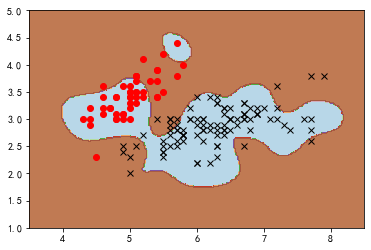

In [13]:
# 运行总结
# 依据真实数据集，标记绘图范围
x_min,x_max=x_vals[:,0].min()-1,x_vals[:,0].max()+1
y_min,y_max=x_vals[:,1].min()-1,x_vals[:,1].max()+1
xx,yy=np.meshgrid(np.arange(x_min,x_max,0.02),
                  np.arange(y_min,y_max,0.02))
# 获取模型预测结果标识
grid_points=np.c_[xx.ravel(),yy.ravel()]
with tf.Session() as sess:
    sess.run(init)
    grid_predictions=sess.run(prediction,
                              feed_dict={x_data:rand_x,
                                         y_target:rand_y,
                                         prediction_grid:grid_points})
    grid_predictions=grid_predictions.reshape(xx.shape)
    # 绘制图形
    plt.contourf(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)
    plt.plot(class1_x,class1_y,'ro')
    plt.plot(class2_x,class2_y,'kx')
    plt.ylim([1,5.0])
    plt.xlim([3.5,8.5])
    plt.show()